In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
import cartopy.crs as ccrs
import csv
from dataclasses import asdict
from datetime import datetime, timedelta
import easygems.healpix as egh
import intake
import matplotlib.pyplot as plt
import numpy as np
import orcestra
import orcestra.flightplan as fp
import orcestra.sat
from orcestra.flightplan import LatLon, IntoCircle, bco, sal, find_ec_lon, vertical_preview, to_kml
import pandas as pd

In [93]:
# Define dates for forecast initialization and flight

issued_time = datetime(2024, 8, 20, 12, 0, 0)

flight_time = datetime(2024, 8, 25, 12, 0, 0)
flight_index = f"HALO-{flight_time.strftime('%Y%m%d')}a"

print(
    f"Initalization date of IFS forecast: {issued_time}\n"
    f"Flight date: {flight_time:%Y-%m-%d}\n"
    f"Flight index: {flight_index}"
)

Initalization date of IFS forecast: 2024-08-20 12:00:00
Flight date: 2024-08-25
Flight index: HALO-20240825a


In [94]:
# Domain definition
# TO DO: replace by global definition once it exists
lon_min, lon_max, lat_min, lat_max = -65, -5, -10, 25

In [95]:
# Load forecast data
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
ds = cat.HIFS(datetime = issued_time).to_dask().pipe(egh.attach_coords)

In [96]:
# Load ec satellite track for 
ec_track = orcestra.sat.SattrackLoader("EARTHCARE", "2024-08-19", kind="PRE").get_track_for_day(f"{flight_time:%Y-%m-%d}")
ec_track = ec_track.sel(time=slice(f"{flight_time:%Y-%m-%d} 06:00", None))
ec_lons, ec_lats = ec_track.lon.values, ec_track.lat.values

In [97]:
def ec_time_at_lat(ec_track, lat):
    e = np.datetime64("2024-08-01")
    s = np.timedelta64(1, "ns")
    return (((ec_track.swap_dims({"time":"lat"}).time - e) / s).interp(lat=lat) * s + e)

**Waypoint definitions**

In [98]:
# Mass flux circle radius (m)
radius = 130e3
atr_radius = 70e3

In [99]:
# Setting region (Cabo Verde vs. Barbados)
band = "east"
airport = sal if band == "east" else bco

In [114]:
# Latitudes where we enter and leave the ec track (visually estimated)
lat_ec_north = 15.0
lat_ec_south = 0.0

In [115]:
# ITCZ edges visually estimated from iwv contours
lat_c_south = 4.0
lat_c_north = 10.0

In [125]:
# Setting lat/lon coordinates

# Points where we get on ec track
north_ec = LatLon(lat_ec_north, find_ec_lon(lat_ec_north, ec_lons, ec_lats), label = "north_ec")
south_ec = LatLon(lat_ec_south, find_ec_lon(lat_ec_south, ec_lons, ec_lats), label = "south_ec")

# Intersection of ITCZ edges with ec track
c_north = LatLon(lat_c_north, find_ec_lon(lat_c_north, ec_lons, ec_lats), label = "c_north")
c_south = LatLon(lat_c_south, find_ec_lon(lat_c_south, ec_lons, ec_lats), label = "c_south")

# Center of middle circle
c_mid = c_south.towards(c_north).assign(label = "c_mid")

# EarthCARE underpass
ec_under = south_ec.towards(c_south).assign(label = "ec_under")
ec_under = ec_under.assign(time=str(ec_time_at_lat(ec_track, ec_under.lat).values)+"Z")

# Define flight track, can be split into different legs
leg_south = [
     airport, 
     north_ec.assign(fl=410),
     south_ec.assign(fl=410),
     ec_under.assign(fl=410),
]

leg_circles = [
     IntoCircle(c_south.assign(fl=430), radius, 360),   
     IntoCircle(c_mid.assign(fl=430), radius, 360), 
     IntoCircle(c_north.assign(fl=450), radius, 360),
]    

leg_home = [
     north_ec.assign(fl=450),
     airport
]

waypoints = leg_south + leg_circles + leg_home 

waypoint_centers = []
for point in waypoints:
    if isinstance(point, IntoCircle):
        point = point.center
    waypoint_centers.append(point)

path = fp.expand_path(waypoints, dx=10e3)

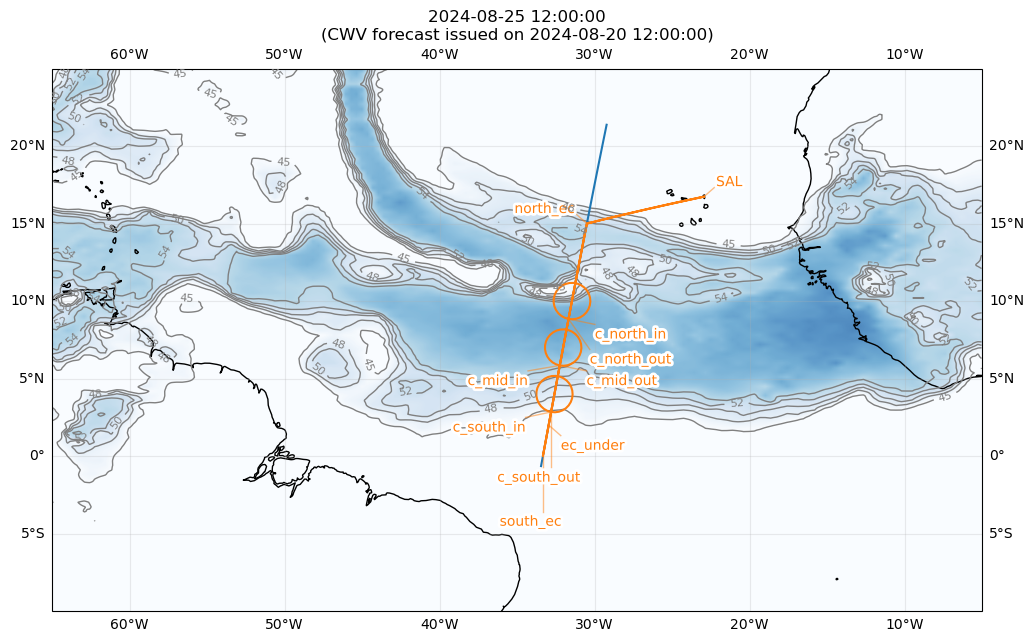

In [126]:
plt.figure(figsize = (12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

cwv_flight_time = ds["tcwv"].sel(time=flight_time, method = "nearest")
fp.plot_cwv(cwv_flight_time, levels = [45.0, 48.0, 50.0, 52.0, 54.0])
plt.title(f"{flight_time}\n(CWV forecast issued on {issued_time})")

plt.plot(ec_lons, ec_lats)
fp.plot_path(path, ax, color="C1")

* EC overpass im Süden (Kreise anpassen)
* ATR?
* METEOR?
* CWV feature?

PI: Julia
WALES: Tanja
SpecMACS: ?
SMART: ?
DS: Theresa + Suolly
HAMP: Jakob

Ground Scientist: Nicolas?

Text(0.5, 1.0, 'Profile')

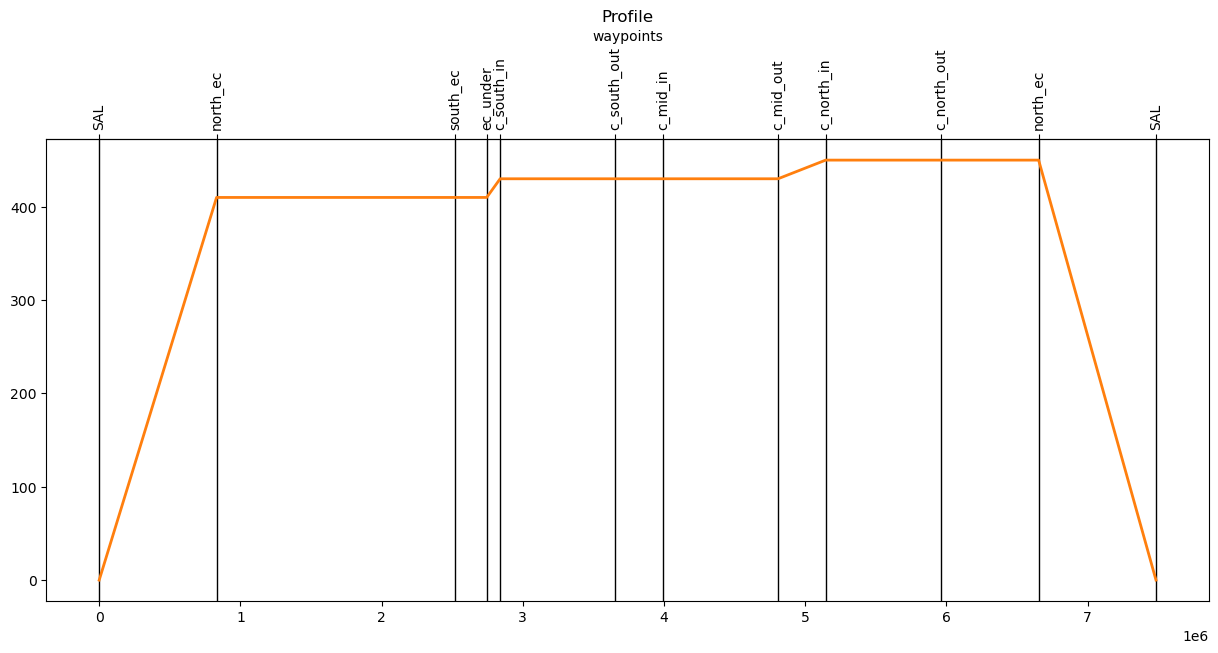

In [127]:
vertical_preview(waypoints)
plt.title("Profile")

In [128]:
path.isel(distance = path.waypoint_indices).to_dataframe().set_index("waypoint_labels")

,waypoint_indices,distance,lon,lat,fl,speed,duration,time
waypoint_labels,,,,,,,,
SAL,0,0.000000e+00,-22.943974,16.734488,0.0,180.724333,0 days 00:00:00,2024-08-25 12:47:47.147330367
north_ec,84,8.312370e+05,-30.495987,15.000000,410.0,234.380889,0 days 01:10:37.615896125,2024-08-25 13:58:24.763226492
south_ec,253,2.519339e+06,-33.332664,0.000000,410.0,234.380889,0 days 03:10:40.002277943,2024-08-25 15:58:27.149608310
ec_under,276,2.744346e+06,-32.960258,2.000067,410.0,234.380889,0 days 03:26:40.009171633,2024-08-25 16:14:27.156502000
c_south_in,286,2.839353e+06,-32.802794,2.844545,430.0,236.541556,0 days 03:33:23.506308867,2024-08-25 16:21:10.653639234
c_south_out,373,3.654514e+06,-32.802794,2.844545,430.0,236.541556,0 days 04:30:49.671365034,2024-08-25 17:18:36.818695401
c_mid_in,407,3.992098e+06,-32.243005,5.845212,430.0,236.541556,0 days 04:54:36.833256005,2024-08-25 17:42:23.980586372
c_mid_out,494,4.807259e+06,-32.243005,5.845212,430.0,236.541556,0 days 05:52:02.998343914,2024-08-25 18:39:50.145674281
c_north_in,528,5.144842e+06,-31.677790,8.845104,450.0,238.445000,0 days 06:15:44.448842161,2024-08-25 19:03:31.596172528


In [120]:
with open(f"{flight_index}.kml", "w") as f:
    f.write(to_kml(path))

In [107]:
# export kml
# export for FX
# export for pilots